# Calculating static grid variables for CM-O suite (mom5) runs


We genarally need the gridpositions, geopositions and geodistances

In [8]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
from mom_read import parse_xgcm_attributes
from mom_budgets import calculate_dzstar
from xgcm import Grid

The grid in MOM5 is given by 4 cell geometries (centerered on) for T(tracer), U(velocity; upper right corner because of B grid), E(Eastern Cell face), and N (northern tracer cell face.)
![title](img/geometry1.png)
![title](img/geometry2.png)
Pictures taken from the [MOM5 manual](https://mom-ocean.github.io/assets/pdfs/MOM5_manual.pdf)

In [3]:
grid_test = xr.open_dataset('/work/Julius.Busecke/CM2.1/siena_201303_fix_rds/static/ocean_grid_etopo_1p0_v2.nc')
grid_test

<xarray.Dataset>
Dimensions:     (grid_x_C: 360, grid_x_T: 360, grid_y_C: 200, grid_y_T: 200, vertex: 4, zb: 50, zt: 50)
Coordinates:
  * zt          (zt) float64 5.034 15.1 25.22 ... 4.975e+03 5.185e+03 5.395e+03
  * zb          (zb) float64 10.07 20.16 30.29 ... 5.08e+03 5.29e+03 5.5e+03
  * grid_x_T    (grid_x_T) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * grid_y_T    (grid_y_T) float64 -81.5 -80.5 -79.5 -78.5 ... 87.5 88.5 89.5
  * grid_x_C    (grid_x_C) float64 -279.0 -278.0 -277.0 ... 78.0 79.0 80.0
  * grid_y_C    (grid_y_C) float64 -81.0 -80.0 -79.0 -78.0 ... 88.0 89.0 90.0
  * vertex      (vertex) float64 1.0 2.0 3.0 4.0
Data variables:
    x_T         (grid_y_T, grid_x_T) float64 ...
    y_T         (grid_y_T, grid_x_T) float64 ...
    x_vert_T    (vertex, grid_y_T, grid_x_T) float64 ...
    y_vert_T    (vertex, grid_y_T, grid_x_T) float64 ...
    area_T      (grid_y_T, grid_x_T) float64 ...
    angle_T     (grid_y_T, grid_x_T) float64 ...
    ds_00_02_T  (grid_y_T, g

In [9]:
def add_static_vert_grid(ds, vgrid_path):
    # Right now I dont have the actual static dz values, so ill take the ones from the physics files...this could probably
    # be done more correctly
    ds_vert = xr.open_dataset(vgrid_path,decode_times=False)
    for co in ['st_ocean', 'sw_ocean','sw_edges_ocean', 'st_edges_ocean']:
        ds.coords[co] = ds_vert[co]
    return ds

def add_static_vert_dens_grid(ds, vgrid_dens_path):
    # Right now I dont have the actual static dz values, so ill take the ones from the physics files...this could probably
    # be done more correctly
    ds_vert = xr.open_dataset(vgrid_dens_path,decode_times=False)
    if 'potrho_edges' in ds_vert.dims:
        rhodims = ['potrho', 'potrho_edges']
    else:
        rhodims = ['potrho']
        
    for co in rhodims:
        ds.coords[co] = ds_vert[co]
        
    return ds



def build_raw_grid(etopo_path):
    """add distances from etopo file"""
    ds = xr.open_mfdataset(etopo_path)
    rename = {
        'grid_y_T': 'yt_ocean',
        'grid_x_T': 'xt_ocean',
        'grid_y_C': 'yu_ocean',
        'grid_x_C': 'xu_ocean',
        'ds_10_12_T': 'dyt',
        'ds_01_21_T': 'dxt',
        'ds_10_12_C': 'dyu',
        'ds_01_21_C': 'dxu',
        'ds_10_12_E': 'dyte',
        'ds_01_21_E': 'dxte',
        'ds_10_12_N': 'dytn',
        'ds_01_21_N': 'dxtn',
        'wet':'wet_t',
        'x_E':'geolon_e',
        'x_N':'geolon_n',
        'x_T':'geolon_t',
        'x_C':'geolon_u',
        'y_E':'geolat_e',
        'y_N':'geolat_n',
        'y_T':'geolat_t',
        'y_C':'geolat_u',
        'area_T': 'area_t',
        'area_C': 'area_u',
        'area_E': 'area_e',
        'area_N': 'area_n',
        'depth_t': 'ht',
        'num_levels':'kmt',
                    }
    if 'wet_c' in ds.data_vars:         
        rename['wet_c'] = 'wet_u'
    
    if 'depth_c' in ds.data_vars:         
        rename['depth_c'] = 'depth_u'
        
    if 'num_levels_c' in ds.data_vars:         
        rename['num_levels_c'] = 'kmu'
        
    ds = ds.rename(rename)
    drop_vars = set(ds.variables) - set(rename.values())
    ds = ds.drop(drop_vars)
    for va in ds.data_vars:
        ds.coords[va] = ds[va]
    return ds

def add_regionmask(ds, mask_path):
    # This will add the umask and tmask from the regional file
    reg_mask = xr.open_dataset(mask_path)
    
    # Load regional mask to get full tmask and umask
    ds.coords['tmask'] = ds['area_t']
    ds.coords['umask'] = ds['area_u']
    
    if 'TMASK' in reg_mask.data_vars:
        tvar = 'TMASK'
        uvar = 'UMASK'
    elif 'tmask' in reg_mask.data_vars:
        tvar = 'tmask'
        uvar = 'umask'
        
    tmask = reg_mask[tvar]
    umask = reg_mask[uvar]
    
    ds.coords['tmask'].data = tmask.data > 0
    ds.coords['umask'].data = umask.data > 0

    ds.coords['tmask_region'] = ds['area_t']
    ds.coords['tmask_region'].data = tmask.data
    ds.coords['umask_region'] = ds['area_u']
    ds.coords['umask_region'].data = umask.data
    return ds

Some of the files below might have to be staged or read from `/archive`, which takes long. So be aware of this before recalculating the grids.

In [16]:
# CM2.6 files
# ocean_vgrid_dens_path = '/work/Julius.Busecke/CM2.6/CM2.6_A_Control-1860_V03/pp/ocean_trans/av/annual_1yr/ocean_trans.02000101.nc' # any file with vertical dens coordinates
ocean_vgrid_dens_path = '/archive/Julius.Busecke/CM2.6/CM2.6_A_Control-1860_V03/pp/stage_ignore/ocean_trans/av/monthly_1yr/01800101.ocean_trans.nc' # any file with vertical dens coordinates
ocean_vgrid_path = '/work/Julius.Busecke/CM2.6/CM2.6_A_Control-1860_V03/pp/ocean/av/annual_1yr/ocean.0200.ann.nc' # any file with vertical coordinates
ocean_grid_etopo_path = '/work/Julius.Busecke/CM2.6/static/ocean_grid_etopo_p1.v9.nc'
ocean_region_mask = '/work/Julius.Busecke/CM2.6/static/regionmask_cm26_020813.nc'
output_path = '/archive/Julius.Busecke/CM2.6/static/grid_complete.nc'

ds_grid = build_raw_grid(ocean_grid_etopo_path)
ds_grid = add_static_vert_grid(ds_grid, ocean_vgrid_path)
ds_grid = add_static_vert_dens_grid(ds_grid, ocean_vgrid_dens_path)
ds_grid = add_regionmask(ds_grid, ocean_region_mask)
ds_grid = parse_xgcm_attributes(ds_grid)
ds_grid = ds_grid.load()
ds_grid.to_netcdf(output_path)
ds_grid

<xarray.Dataset>
Dimensions:         (potrho: 80, potrho_edges: 81, st_edges_ocean: 51, st_ocean: 50, sw_edges_ocean: 51, sw_ocean: 50, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
    geolon_t        (yt_ocean, xt_ocean) float64 -279.9 -279.8 ... 80.0 80.0
    geolat_t        (yt_ocean, xt_ocean) float64 -81.11 -81.11 ... 65.06 65.02
    area_t          (yt_ocean, xt_ocean) float64 8.072e+06 ... 3.664e+04
    dxt             (yt_ocean, xt_ocean) float64 1.719e+03 ... 4.697e+03
    dyt             (yt_ocean, xt_ocean) float64 4.697e+03 4.697e+03 ... 7.804
    geolon_e        (yt_ocean, xu_ocean) float64 -279.9 -279.8 ... 80.0 80.0
    geolat_e      

In [18]:
# CM2.1 files
ocean_vgrid_dens_path = '/work/Julius.Busecke/CM2.1/siena_201303_fix_rds/CM_O1p0_C180_A02-topaz-bling-minibling-ctrl-restart_bgc/pp/ocean_trans/av/monthly_1yr/02000101.ocean_trans.nc'
ocean_vgrid_path = '/work/Julius.Busecke/CM2.1/siena_201303_fix_rds/CM_O1p0_C180_A02-topaz-bling-minibling-ctrl-restart_bgc/pp/ocean/av/monthly_1yr/02000101.ocean.nc' # any file with vertical coordinates
ocean_grid_etopo_path = '/archive/Julius.Busecke/CM2.1/siena_201303_fix_rds/static/ocean_grid_etopo_1p0_v2.nc'
ocean_region_mask = '/archive/Julius.Busecke/CM2.1/siena_201303_fix_rds/static/grid_spec_v6_regMask.nc'
output_path = '/archive/Julius.Busecke/CM2.1/siena_201303_fix_rds/static/grid_complete.nc'

ds_grid = build_raw_grid(ocean_grid_etopo_path)
ds_grid = add_static_vert_grid(ds_grid, ocean_vgrid_path)
ds_grid = add_static_vert_dens_grid(ds_grid, ocean_vgrid_dens_path)
ds_grid = add_regionmask(ds_grid, ocean_region_mask)
ds_grid = parse_xgcm_attributes(ds_grid)
ds_grid = ds_grid.load()
ds_grid.to_netcdf(output_path)
ds_grid

<xarray.Dataset>
Dimensions:         (potrho: 80, potrho_edges: 81, st_edges_ocean: 51, st_ocean: 50, sw_edges_ocean: 51, sw_ocean: 50, xt_ocean: 360, xu_ocean: 360, yt_ocean: 200, yu_ocean: 200)
Coordinates:
  * xt_ocean        (xt_ocean) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * yt_ocean        (yt_ocean) float64 -81.5 -80.5 -79.5 ... 87.5 88.5 89.5
  * xu_ocean        (xu_ocean) float64 -279.0 -278.0 -277.0 ... 78.0 79.0 80.0
  * yu_ocean        (yu_ocean) float64 -81.0 -80.0 -79.0 ... 88.0 89.0 90.0
    geolon_t        (yt_ocean, xt_ocean) float64 -279.5 -278.5 ... 79.94 79.98
    geolat_t        (yt_ocean, xt_ocean) float64 -81.5 -81.5 ... 65.63 65.21
    area_t          (yt_ocean, xt_ocean) float64 1.828e+09 ... 8.518e+07
    dxt             (yt_ocean, xt_ocean) float64 1.644e+04 ... 4.663e+04
    dyt             (yt_ocean, xt_ocean) float64 1.112e+05 ... 1.834e+03
    geolon_e        (yt_ocean, xu_ocean) float64 -279.0 -278.0 ... 79.96 80.0
    geolat_e        (yt_ocea

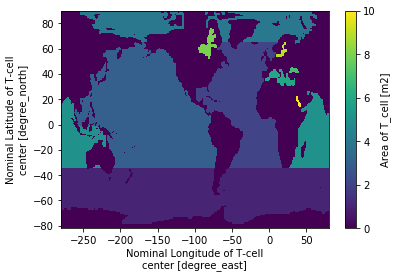

In [19]:
ds_grid.tmask_region.plot()

xt_ocean
yt_ocean
xu_ocean
yu_ocean
geolon_t
geolat_t
geolon_u
geolat_u
ht


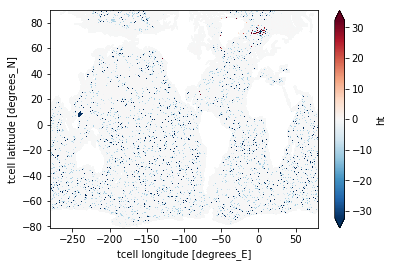

hu


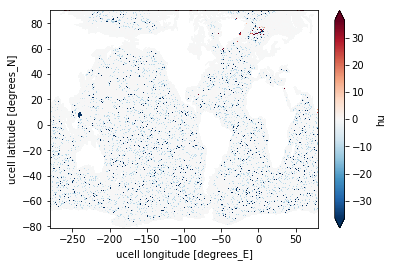

area_t


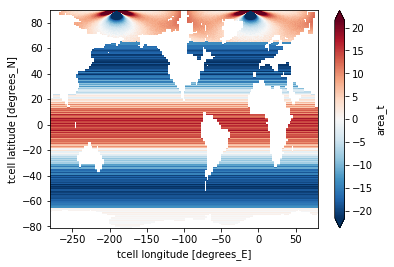

area_u


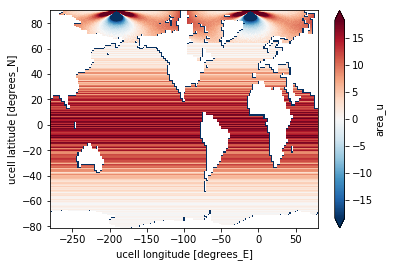

kmt


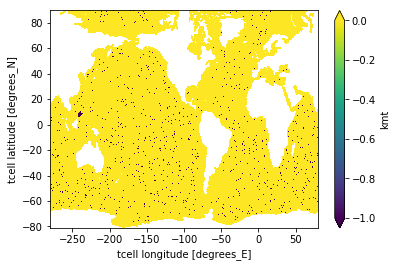

kmu


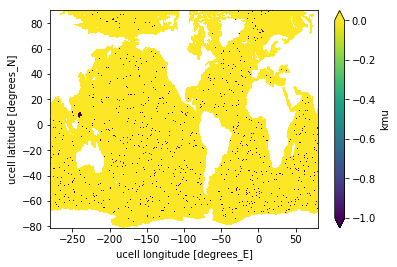

dyu
dxu
dyt
wet_t
dxt
geolat_e
geolon_e
geolat_n
geolon_n
st_ocean
sw_ocean
sw_edges_ocean
st_edges_ocean
tmask
umask
tmask_region
umask_region
dyte
dxtn


In [20]:
#####################################
# Compatibility test with old output #
#####################################
import numpy as np

ds_test_old = xr.open_dataset('/work/Julius.Busecke/CM2.6/static/grid_complete.old.nc') \
    .rename({'wet':'wet_t', 'geolon_c':'geolon_u', 'geolat_c':'geolat_u'})
    
ds_test_new = xr.open_dataset('/work/Julius.Busecke/CM2.6/static/grid_complete.nc').drop(['area_n', 'area_e'])



for co in ds_test_old.coords:
    print(co)
    nan1 = xr.ufuncs.isnan(ds_test_old[co])
    nan2 = xr.ufuncs.isnan(ds_test_new[co])
    xor_nanmask = xr.ufuncs.logical_xor(nan1, nan2)
    zero1 = ds_test_old[co] == 0
    zero2 = ds_test_new[co] == 0
    
    nanmask = xr.ufuncs.logical_or(nan1, nan2)
    zeromask = xr.ufuncs.logical_or(zero1, zero2)
    mask = xr.ufuncs.logical_or(nanmask, zeromask)
    
    if co not in ['ht', 'hu', 'area_t', 'area_u', 'kmt', 'kmu']: #ht has a different mariana trench?
        np.testing.assert_allclose(ds_test_old[co].where(~mask).data, ds_test_new[co].where(~mask).data)
    else:
        if len(list(ds_test_new[co].dims))>1:
            (ds_test_old[co].where(~mask) - ds_test_new[co].where(~mask)).plot(robust=True)
            plt.show()